# This notebook defines Level 1 sub-macro regions based on the L0 macro regions.
It follows the same flow as L0: load the Admin 0_all_layers dataset,
prepare names/codes, define L1 sub-macro regions, validate coverage,
and plot results.


## 1. Load data


In [29]:
from pathlib import Path
import geopandas as gpd

base_dir = Path.cwd().parents[0]
data_dir = base_dir / "Data" / "World Bank Official Boundaries - Admin 0_all_layers"
shp_path = data_dir / "WB_GAD_ADM0_complete_H2RES.shp"
gdf = gpd.read_file(shp_path)

# Helpers to process country statistics

In [73]:
import pandas as pd

# -----------------------------------
# LOAD COUNTRY-LEVEL STATISTICS
# -----------------------------------
stats_path = base_dir / "Data" / "Lastest_country_statistics.xlsx"
stats_df = pd.read_excel(stats_path)
stats_df = stats_df[stats_df["Country Code"] != "WLD"].copy()

# -----------------------------------
# BUILD ISO3 EFFECTIVE COLUMN (if missing)
# -----------------------------------
if "ISO_A3_EFF" not in gdf.columns:
    if "ISO_A3_CUSTOM" in gdf.columns:
        gdf["ISO_A3_EFF"] = gdf["ISO_A3"]
        mask_missing = gdf["ISO_A3_EFF"].isna() | (gdf["ISO_A3_EFF"].str.strip() == "")
        gdf.loc[mask_missing, "ISO_A3_EFF"] = gdf.loc[mask_missing, "ISO_A3_CUSTOM"]
    else:
        gdf["ISO_A3_EFF"] = gdf["ISO_A3"]

# -----------------------------------
# HELPER: STATS PER SUBREGION
# -----------------------------------
def build_region_stats(region_dict, region_label, gdf, stats_df):
    lookup = (
        gdf[["NAM_0", "ISO_A3_EFF"]]
        .dropna()
        .rename(columns={"NAM_0": "NAME", "ISO_A3_EFF": "ISO3"})
        .drop_duplicates()
    )

    rows = []
    for region, country_names in region_dict.items():
        iso_codes = lookup[lookup["NAME"].isin(country_names)]["ISO3"].unique()
        sub = stats_df[stats_df["Country Code"].isin(iso_codes)]

        rows.append({
            "Region": region.replace("_", " "),
            "Population (MM)": sub["Population"].sum() / 1e6,
            "GDP (BUSD)": sub["GDP (Million USD)"].sum() / 1e3,
            "Electricity Consumption (TWh)": sub["Country electricity consumption (GWh)"].sum() / 1e3
        })

    out = pd.DataFrame(rows).round(2)
    print(f"--- {region_label} ---")
    return out

## 3. Define L1 sub-macro regions (LAC)


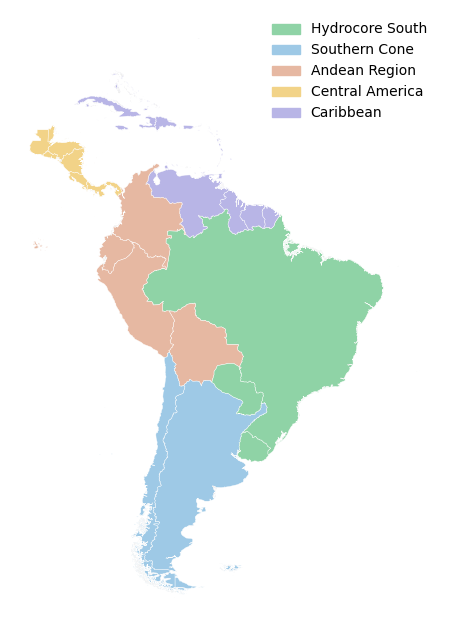

--- LAC ---


,Region,Population (MM),GDP (BUSD),Electricity Consumption (TWh)
0,Hydrocore South,222.31,2304.83,647.00
1,Southern Cone,65.46,963.53,214.39
2,Andean Region,117.65,882.11,175.97
3,Central America,52.55,390.48,55.04
4,Caribbean,73.41,1004.90,104.02


In [74]:
from pathlib import Path
import geopandas as gpd
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from IPython.display import display

# --- LISTS ---
SOUTH_AMERICA = [
    'Anguilla (U.K.)','Aruba (Neth.)','Antigua and Barbuda','Argentina',
    'Barbados','Belize','Bermuda (U.K.)','Bonaire, Sint Eustatius and Saba (Neth.)',
    'British Virgin Islands (U.K.)','Cayman Islands (U.K.)',
    'Bolivia','Brazil','Curacao (Neth.)','Cuba','Chile','Colombia','Costa Rica','Dominica',
    'Dominican Republic','Ecuador','El Salvador','Grenada','Guatemala',
    'Guyana','Haiti','Honduras','Jamaica','Nicaragua','Panama',
    'Paraguay','Peru','Republica Bolivariana de Venezuela','Saint Kitts and Nevis',
    'Saint Lucia','Saint Vincent and the Grenadines','Suriname','The Bahamas',
    'Trinidad and Tobago','Uruguay','Falkland Islands','Montserrat (U.K.)',
    'Puerto Rico (U.S.)','Saint-Barthelemy (Fr.)','Saint-Martin (Fr.)',
    'Sint Maarten (Neth.)','Turks and Caicos Islands (U.K.)','United States Virgin Islands (U.S.)',
    'French Guyana','Guadalupe (Fr.)','Martinique (Fr.)'
]

LAC_REGIONS = {
    'Hydrocore South': [
        'Brazil','Uruguay','Paraguay'
    ],
    'Southern Cone': [
        'Argentina','Chile','Falkland Islands'
    ],
    'Andean Region': [
        'Colombia','Peru','Ecuador','Bolivia'
    ],
    'Central America': [
        'Belize','Guatemala','Honduras','El Salvador',
        'Nicaragua','Costa Rica','Panama'
    ],
    'Caribbean': [
        'Cuba','Haiti','Dominican Republic','Jamaica','Trinidad and Tobago',
        'The Bahamas','Barbados','Grenada','Dominica',
        'Antigua and Barbuda','Saint Kitts and Nevis','Saint Lucia',
        'Saint Vincent and the Grenadines',
        'Anguilla (U.K.)','Aruba (Neth.)','Bermuda (U.K.)','British Virgin Islands (U.K.)',
        'Cayman Islands (U.K.)','Curacao (Neth.)','Montserrat (U.K.)','Puerto Rico (U.S.)',
        'Saint-Barthelemy (Fr.)','Saint-Martin (Fr.)','Sint Maarten (Neth.)',
        'Turks and Caicos Islands (U.K.)','United States Virgin Islands (U.S.)',
        'Republica Bolivariana de Venezuela','Suriname','Guyana','French Guyana',
        'Guadalupe (Fr.)','Martinique (Fr.)','Bonaire, Sint Eustatius and Saba (Neth.)'
    ]
}

colors = {
    "Hydrocore South": "#8FD3A6",
    "Southern Cone": "#9EC9E6",
    "Andean Region": "#E6B8A2",
    "Central America": "#F2D388",
    "Caribbean": "#B8B5E6"
}

# --- ASSIGN SUBREGIONS ---
lac_gdf = gdf[gdf["NAM_0"].isin(SOUTH_AMERICA)].copy()
lac_gdf["LAC_Region"] = None
for region, countries in LAC_REGIONS.items():
    lac_gdf.loc[lac_gdf["NAM_0"].isin(countries), "LAC_Region"] = region

# --- LIGHTWEIGHT MAP ---
lac_plot = lac_gdf.copy()
lac_plot["geometry"] = lac_plot["geometry"].simplify(0.05, preserve_topology=True)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_LAC.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
lac_plot.plot(
    ax=ax,
    color=lac_plot["LAC_Region"].map(colors),
    linewidth=0.3,
    edgecolor="white"
)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="upper right", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()  

lac_stats = build_region_stats(LAC_REGIONS, "LAC", gdf, stats_df)
display(lac_stats)  

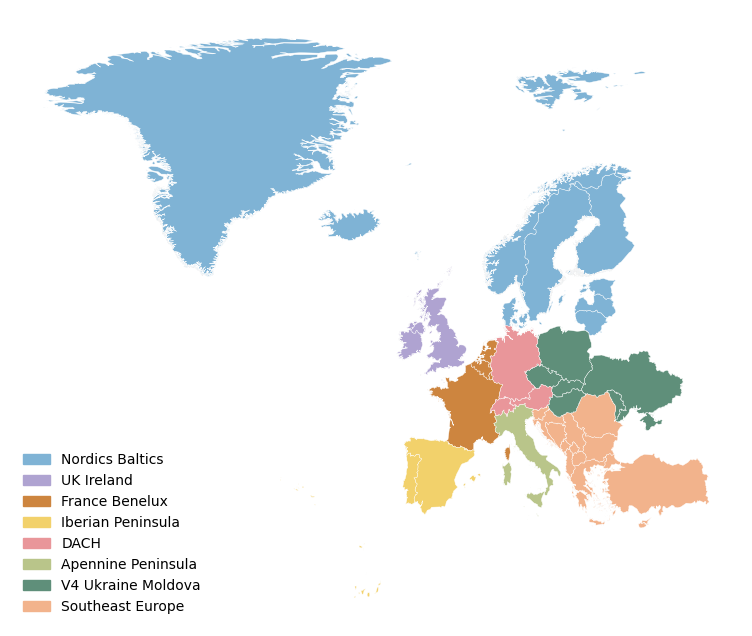

--- Europe ---


,Region,Population (MM),GDP (BUSD),Electricity Consumption (TWh)
0,Nordics Baltics,34.39,2034.99,422.70
1,UK Ireland,74.69,4228.65,324.38
2,France Benelux,99.10,5157.38,641.47
3,Iberian Peninsula,59.63,2035.47,305.10
4,DACH,101.76,6126.42,628.79
5,Apennine Peninsula,59.59,2398.92,300.58
6,V4 Ukraine Moldova,102.67,1833.36,395.50
7,Southeast Europe,145.18,2457.23,540.24


In [80]:
# EUROPE 
EUROPE = [
    'Aaland (Fin.)','Albania','Andorra','Austria','Belgium','Bosnia and Herzegovina',
    'Bulgaria','Croatia','Czech Republic','Denmark','Estonia','Faroe Islands (Den.)',
    'Finland','France','Germany','Greece','Guernsey (U.K.)','Hungary','Iceland',
    'Ireland','Isle of Man (U.K.)','Italy','Jersey (U.K.)','Kosovo','Latvia',
    'Liechtenstein','Lithuania','Luxembourg','Malta','Moldova','Monaco',
    'Montenegro','Netherlands','North Macedonia','Norway','Poland',
    'Portugal','Serbia','Romania','San Marino','Slovak Republic','Slovenia',
    'Spain','Sweden','Switzerland','Ukraine','United Kingdom','Vatican City',
    'Turkey','Greenland (Den.)','Cyprus','Gibraltar (U.K.)',
    'Svalbard and Jan Mayen (Nor.)'
    #'Sovereign Base Areas of Akrotiri and Dhekelia (U.K.)', 'UN Buffer Zone'
]

EUROPE_REGIONS = {
    "Nordics Baltics": [
        "Denmark","Finland","Iceland","Norway","Sweden",
        "Estonia","Latvia","Lithuania",
        "Aaland (Fin.)","Faroe Islands (Den.)","Greenland (Den.)",
        "Svalbard and Jan Mayen (Nor.)"
    ],
    "UK Ireland": [
        "United Kingdom","Ireland",
        "Isle of Man (U.K.)","Guernsey (U.K.)","Jersey (U.K.)"
    ],
    "France Benelux": [
        "France","Belgium","Netherlands",
        "Luxembourg","Monaco"
    ],
    "Iberian Peninsula": [
        "Spain","Portugal","Andorra", "Gibraltar (U.K.)"
    ],
    "DACH": [
        "Germany","Austria","Switzerland","Liechtenstein"
    ],
    "Apennine Peninsula": [
        "Italy","San Marino","Vatican City","Malta"
    ],
    "V4 Ukraine Moldova": [
        "Poland","Czech Republic","Slovak Republic","Hungary",
        "Ukraine","Moldova"
    ],
    "Southeast Europe": [
        "Albania","Bosnia and Herzegovina","Bulgaria","Croatia",
        "Greece","Kosovo","Montenegro","North Macedonia",
        "Romania","Serbia","Slovenia",
        "Turkey","Cyprus"

        
    ]
}


import matplotlib.patches as mpatches

colors = {
    "Nordics Baltics": "#7FB3D5",
    "UK Ireland": "#AFA3D1",
    "France Benelux": "#CD853F",
    "Iberian Peninsula": "#F2D16B",
    "DACH": "#E9969A",
    "Apennine Peninsula": "#B9C58A",
    "V4 Ukraine Moldova": "#5F8F7A",
    "Southeast Europe": "#F2B38C"
}

# --- ASSIGN SUBREGIONS ---
europe_gdf = gdf[gdf["NAM_0"].isin(EUROPE)].copy()
europe_gdf["EUROPE_Region"] = None
for region, countries in EUROPE_REGIONS.items():
    europe_gdf.loc[europe_gdf["NAM_0"].isin(countries), "EUROPE_Region"] = region

# --- LIGHTWEIGHT MAP ---
europe_plot = europe_gdf.copy()
europe_plot["geometry"] = europe_plot["geometry"].simplify(0.05, preserve_topology=True)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_Europe.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
color_series = europe_plot["EUROPE_Region"].map(colors)

europe_plot.plot(
    ax=ax,
    color=color_series,
    linewidth=0.3,
    edgecolor="white"
)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="lower left", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()  

europe_stats = build_region_stats(EUROPE_REGIONS, "Europe", gdf, stats_df)
display(europe_stats)  

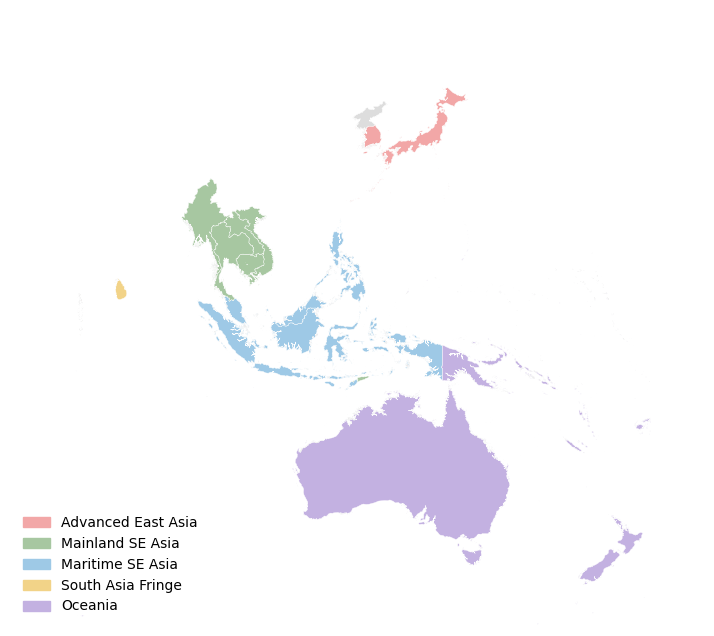

--- Asia-Pacific ---


,Region,Population (MM),GDP (BUSD),Electricity Consumption (TWh)
0,Advanced East Asia,175.73,5739.00,1540.34
1,Mainland SE Asia,253.97,1141.62,521.01
2,Maritime SE Asia,451.97,2875.28,753.52
3,South Asia Fringe,22.44,105.94,14.99
4,Oceania,46.68,2081.77,309.67


In [94]:
# ASIA REST
ASIA_REST = [
    "Brunei Darussalam","Cambodia","Japan","Indonesia","Lao People's Democratic Republic",
    "Malaysia","Maldives","Myanmar",
    "D. P. R. of Korea","Philippines","Republic of Korea","Singapore",
    "Sri Lanka","Thailand","Timor-Leste","Viet Nam"
]

# OCEANIA
OCEANIA = [
    "Australia","Fiji","Kiribati","Marshall Islands","Federated States of Micronesia","Nauru",
    "New Zealand","Palau","Papua New Guinea","Solomon Islands","Tonga",
    "Tuvalu","Vanuatu","Samoa",
    "American Samoa (U.S.)","Cook Islands (N.Z.)","French Polynesia (Fr.)","Guam (U.S.)","Northern Mariana Islands (U.S.)",
    "New Caledonia (Fr.)","Niue (N.Z.)","Norfolk Island (Aus.)","Pitcairn Islands (U.K.)",
    "Wallis and Futuna (Fr.)","Heard Island and McDonald Islands (Aus.)",
    "Ashmore and Cartier Islands (Aus.)","British Indian Ocean Territory","Christmas Island (Aus.)",
    "Cocos (Keeling) Islands (Aus.)","Tokelau (N.Z.)"
]

ASIA_PACIFIC = ASIA_REST + OCEANIA

# -----------------------------------
# ASIA-PACIFIC SUBREGIONS (5)
# -----------------------------------
ASIA_PACIFIC_REGIONS = {
    "Advanced East Asia": [
        "Japan","Republic of Korea"
        # "D. P. R. of Korea" # Excluded due to lack of data
    ],
    "Mainland SE Asia": [
        "Viet Nam","Thailand","Cambodia","Lao People's Democratic Republic","Myanmar","Timor-Leste"
    ],
    "Maritime SE Asia": [
        "Indonesia","Philippines","Malaysia","Brunei Darussalam","Singapore",
        "Papua New Guinea"
    ],
    "South Asia Fringe": [
        "Sri Lanka","Maldives"
    ],
    "Oceania": OCEANIA
}

colors = {
    "Advanced East Asia": "#F2A7A7",
    "Mainland SE Asia": "#A7C7A1",
    "Maritime SE Asia": "#9EC9E6",
    "South Asia Fringe": "#F2D388",
    "Oceania": "#C3B1E1"
}

import matplotlib.patches as mpatches

# --- ASSIGN SUBREGIONS ---
ap_gdf = gdf[gdf["NAM_0"].isin(ASIA_PACIFIC)].copy()
ap_gdf["AP_Region"] = None
for region, countries in ASIA_PACIFIC_REGIONS.items():
    ap_gdf.loc[ap_gdf["NAM_0"].isin(countries), "AP_Region"] = region

# --- LIGHTWEIGHT MAP ---
ap_plot = ap_gdf.copy()
ap_plot["geometry"] = ap_plot["geometry"].simplify(0.05, preserve_topology=True)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_AsiaPacific.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
color_series = ap_plot["AP_Region"].map(colors).fillna("#DDDDDD")

ap_plot.plot(
    ax=ax,
    color=color_series,
    linewidth=0.3,
    edgecolor="white"
)

# Recorte de vista para Asia-Pacífico
ax.set_xlim(60, 190)
ax.set_ylim(-55, 60)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="lower left", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()  

ap_stats = build_region_stats(ASIA_PACIFIC_REGIONS, "Asia-Pacific", gdf, stats_df)
display(ap_stats)  

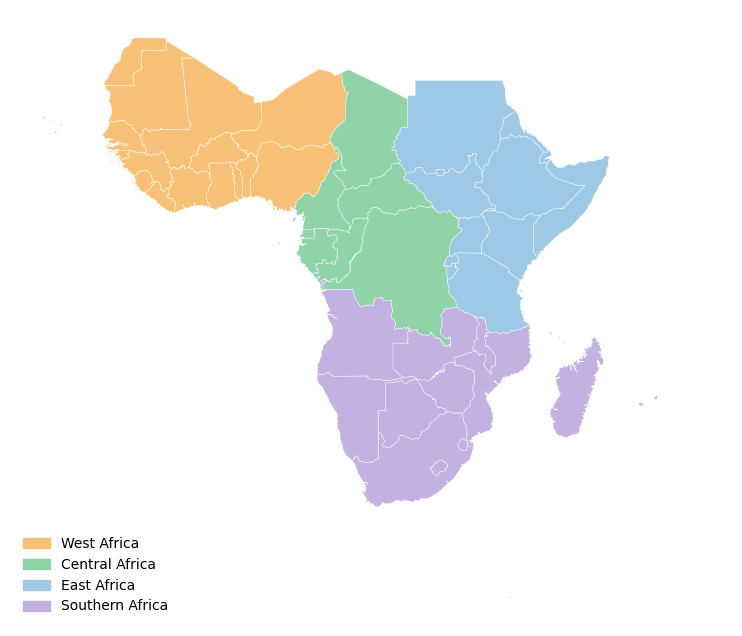

--- Sub-Saharan Africa ---


,Region,Population (MM),GDP (BUSD),Electricity Consumption (TWh)
0,West Africa,456.25,545.97,76.63
1,Central Africa,175.03,195.57,29.85
2,East Africa,422.47,484.00,51.85
3,Southern Africa,238.49,656.91,275.11


In [95]:
# AFRICA
SUBSAHARAN_AFRICA = ["Abyei",'Angola', 'Benin', 'Botswana', 'Burkina Faso', 'Burundi', 'Cabo Verde',
           'Cameroon', 'Central African Republic', 'Chad', 'Comoros', 'Congo', 
           "Cote d'Ivoire", 'Democratic Republic of Congo', 'Equatorial Guinea', 
           'Eritrea', 'Eswatini', 'Ethiopia', 'Gabon', 'Ghana', 'Guinea', 
           'Guinea-Bissau', 'Kenya', 'Lesotho', 'Liberia', 'Madagascar', 
           'Malawi', 'Mali', 'Mauritania', 'Mauritius', 'Mozambique', 
           'Namibia', 'Niger', 'Nigeria', 'Rwanda', 'Senegal', 'Seychelles', 
           'Sierra Leone', 'Somalia', 'South Africa', 'South Sudan', 'Sudan', 
           'Sao Tome and Principe', 'Tanzania', 'The Gambia', 'Togo', 
           'Uganda', 'Zambia', 'Zimbabwe', 'Ilemi Triangle', 'Western Sahara','Djibouti',
           "Reunion (Fr.)", 'Mayotte (Fr.)']

# -----------------------------------
# SSA SUBREGIONS (4) — aligned to your names
# -----------------------------------
SSA_REGIONS = {
    "West Africa": [
        "Benin","Burkina Faso","Cabo Verde","Cote d'Ivoire","The Gambia","Ghana",
        "Guinea","Guinea-Bissau","Liberia","Mali","Mauritania","Niger",
        "Nigeria","Senegal","Sierra Leone","Togo", 'Western Sahara'
    ],
    "Central Africa": [
        "Cameroon","Central African Republic","Chad","Congo","Democratic Republic of Congo",
        "Equatorial Guinea","Gabon","Sao Tome and Principe"
    ],
    "East Africa": [
        "Burundi","Comoros","Djibouti","Eritrea","Ethiopia","Kenya",
        "Rwanda","Seychelles","Somalia","South Sudan",
        "Sudan","Tanzania","Uganda", 'Abyei', 'Ilemi Triangle'
    ],
    "Southern Africa": [
        "Angola","Botswana","Eswatini","Lesotho","Madagascar","Malawi",
        "Mauritius","Mozambique","Namibia","South Africa","Zambia","Zimbabwe",
        'Mayotte (Fr.)', 'Reunion (Fr.)'
    ]
}

import matplotlib.patches as mpatches

colors = {
    "West Africa":    "#F6C177",
    "Central Africa": "#8FD3A6",
    "East Africa":    "#9EC9E6",
    "Southern Africa":"#C3B1E1"
}

# --- ASSIGN SUBREGIONS ---
ssa_gdf = gdf[gdf["NAM_0"].isin(SUBSAHARAN_AFRICA)].copy()
ssa_gdf["SSA_Region"] = None
for region, countries in SSA_REGIONS.items():
    ssa_gdf.loc[ssa_gdf["NAM_0"].isin(countries), "SSA_Region"] = region

# --- LIGHTWEIGHT MAP ---
ssa_plot = ssa_gdf.copy()
ssa_plot["geometry"] = ssa_plot["geometry"].simplify(0.05, preserve_topology=True)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_SSA.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ssa_plot.plot(
    ax=ax,
    color=ssa_plot["SSA_Region"].map(colors),
    linewidth=0.3,
    edgecolor="white"
)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="lower left", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()  

ssa_stats = build_region_stats(SSA_REGIONS, "Sub-Saharan Africa", gdf, stats_df)
display(ssa_stats)  

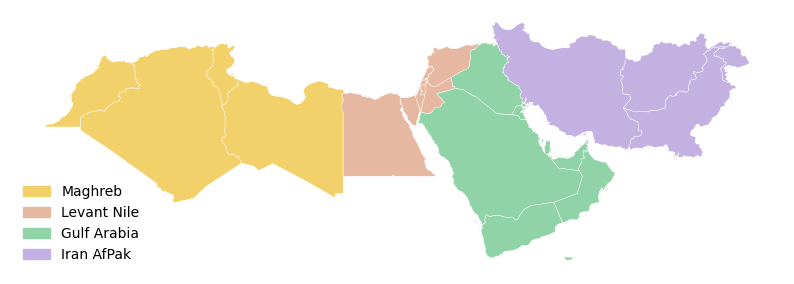

--- MENA ---


,Region,Population (MM),GDP (BUSD),Electricity Consumption (TWh)
0,Maghreb,104.55,518.10,172.51
1,Levant Nile,173.83,1036.58,283.18
2,Gulf Arabia,147.50,2608.75,823.85
3,Iran AfPak,385.48,827.13,487.74


In [82]:
# MENA
MENA = ['Afghanistan','Algeria', 'Arab Republic of Egypt', 'Bahrain', 
        'Iraq', 'Islamic Republic of Iran', 'Jordan', 'Kuwait', 'Lebanon', 'Libya', 
        'Morocco', 'Oman', 
        'Qatar', 'Republic of Yemen', 'Saudi Arabia', 'Syrian Arab Republic', 'Tunisia', 
        'United Arab Emirates', 'West Bank and Gaza', 'Pakistan', 'Gilgit Baltistan',
        'Israel', 'Golan Heights', 'Shebaa Farms Dispute']

MENA_REGIONS = {
    "Maghreb": [
        "Algeria","Morocco","Tunisia","Libya"
    ],
    "Levant Nile": [
        "Arab Republic of Egypt","Jordan","Lebanon","Syrian Arab Republic",
        "Israel","West Bank and Gaza","Golan Heights","Shebaa Farms Dispute"
    ],
    "Gulf Arabia": [
        "Bahrain","Kuwait","Oman","Qatar","Saudi Arabia",
        "United Arab Emirates","Iraq","Republic of Yemen"
    ],
    "Iran AfPak": [
        "Islamic Republic of Iran","Afghanistan","Pakistan","Gilgit Baltistan"
    ]
}


import matplotlib.patches as mpatches

colors = {
    "Maghreb": "#F2D16B",
    "Levant Nile": "#E6B8A2",
    "Gulf Arabia": "#8FD3A6",
    "Iran AfPak": "#C3B1E1",
}


mena_gdf = gdf[gdf["NAM_0"].isin(MENA)].copy()
mena_gdf["MENA_Region"] = None
for region, countries in MENA_REGIONS.items():
    mena_gdf.loc[mena_gdf["NAM_0"].isin(countries), "MENA_Region"] = region

mena_plot = mena_gdf.copy()
mena_plot["geometry"] = mena_plot["geometry"].simplify(0.05, preserve_topology=True)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_MENA.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
mena_plot.plot(
    ax=ax,
    color=mena_plot["MENA_Region"].map(colors),
    linewidth=0.3,
    edgecolor="white"
)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="lower left", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()  

mena_stats = build_region_stats(MENA_REGIONS, "MENA", gdf, stats_df)
display(mena_stats)

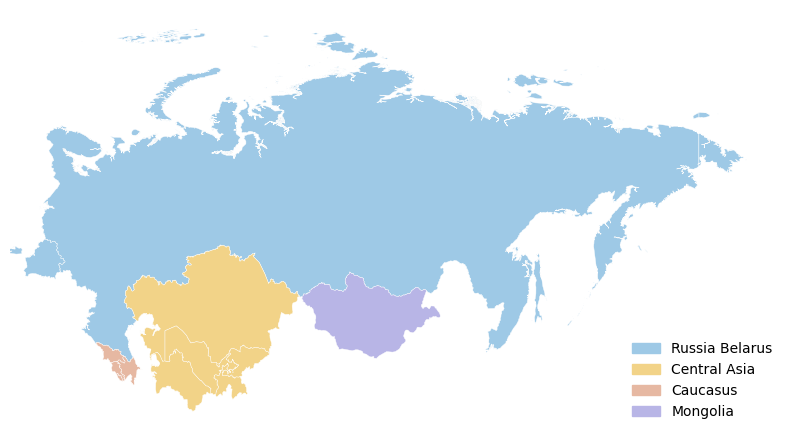

--- Eurasia ---


,Region,Population (MM),GDP (BUSD),Electricity Consumption (TWh)
0,Russia Belarus,152.67,2249.80,1066.85
1,Central Asia,82.26,499.29,233.18
2,Caucasus,16.91,133.88,43.87
3,Mongolia,3.52,23.59,8.97


In [90]:
from shapely.ops import transform
import matplotlib.patches as mpatches

# EURASIA
EURASIA = [
    "Russian Federation","Belarus",
    "Kazakhstan","Uzbekistan","Turkmenistan",
    "Kyrgyz Republic","Tajikistan",
    "Armenia","Azerbaijan","Georgia",
    "Mongolia"
]

EURASIA_REGIONS = {
    "Russia Belarus": [
        "Russian Federation","Belarus"
    ],
    "Central Asia": [
        "Kazakhstan","Uzbekistan","Turkmenistan","Kyrgyz Republic","Tajikistan"
    ],
    "Caucasus": [
        "Armenia","Azerbaijan","Georgia"
    ],
    "Mongolia": [
        "Mongolia"
    ]
}

colors = {
    "Russia Belarus": "#9EC9E6",
    "Central Asia": "#F2D388",
    "Caucasus": "#E6B8A2",
    "Mongolia": "#B8B5E6"
}

# --- ASSIGN SUBREGIONS ---
eur_gdf = gdf[gdf["NAM_0"].isin(EURASIA)].copy()
eur_gdf["EURASIA_Region"] = None
for region, countries in EURASIA_REGIONS.items():
    eur_gdf.loc[eur_gdf["NAM_0"].isin(countries), "EURASIA_Region"] = region

# --- LIGHTWEIGHT MAP ---
eur_plot = eur_gdf.copy()
eur_plot["geometry"] = eur_plot["geometry"].simplify(0.05, preserve_topology=True)

# Fix antimeridian split (shift to 0..360)
eur_plot = eur_plot.to_crs("EPSG:4326")
def shift_antimeridian(geom):
    def _shift(x, y, z=None):
        if x < 0:
            x += 360
        return (x, y) if z is None else (x, y, z)
    return transform(_shift, geom)

eur_plot["geometry"] = eur_plot["geometry"].apply(shift_antimeridian)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_Eurasia.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
eur_plot.plot(
    ax=ax,
    color=eur_plot["EURASIA_Region"].map(colors),
    linewidth=0.3,
    edgecolor="white"
)

# Keep a focused view
ax.set_xlim(20, 200)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="lower right", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

eurasia_stats = build_region_stats(EURASIA_REGIONS, "Eurasia", gdf, stats_df)
display(eurasia_stats)



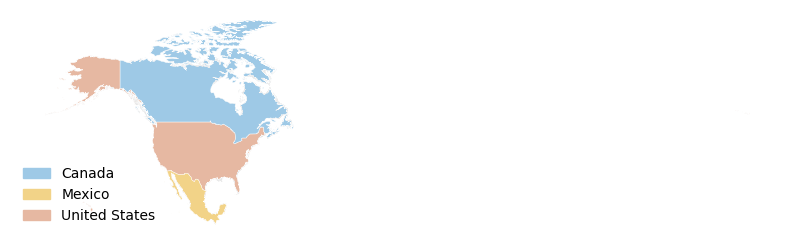

--- North America ---


,Region,Population (MM),GDP (BUSD),Electricity Consumption (TWh)
0,Canada,41.29,2241.25,597.03
1,Mexico,130.86,1852.72,341.35
2,United States,340.11,29184.90,4268.81


In [91]:
# NORTH AMERICA
NORTH_AMERICA = ['Canada','Mexico','United States of America']

NORTH_AMERICA_REGIONS = {
    "Canada": ["Canada"],
    "Mexico": ["Mexico"],
    "United States": ["United States of America"]
}

import matplotlib.patches as mpatches

colors = {
    "Canada": "#9EC9E6",
    "Mexico": "#F2D388",
    "United States": "#E6B8A2"
}

# --- ASSIGN SUBREGIONS ---
na_gdf = gdf[gdf["NAM_0"].isin(NORTH_AMERICA)].copy()
na_gdf["NA_Region"] = None
for region, countries in NORTH_AMERICA_REGIONS.items():
    na_gdf.loc[na_gdf["NAM_0"].isin(countries), "NA_Region"] = region

# --- LIGHTWEIGHT MAP ---
na_plot = na_gdf.copy()
na_plot["geometry"] = na_plot["geometry"].simplify(0.05, preserve_topology=True)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_NorthAmerica.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
na_plot.plot(
    ax=ax,
    color=na_plot["NA_Region"].map(colors),
    linewidth=0.3,
    edgecolor="white"
)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="lower left", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

na_stats = build_region_stats(NORTH_AMERICA_REGIONS, "North America", gdf, stats_df)
display(na_stats)


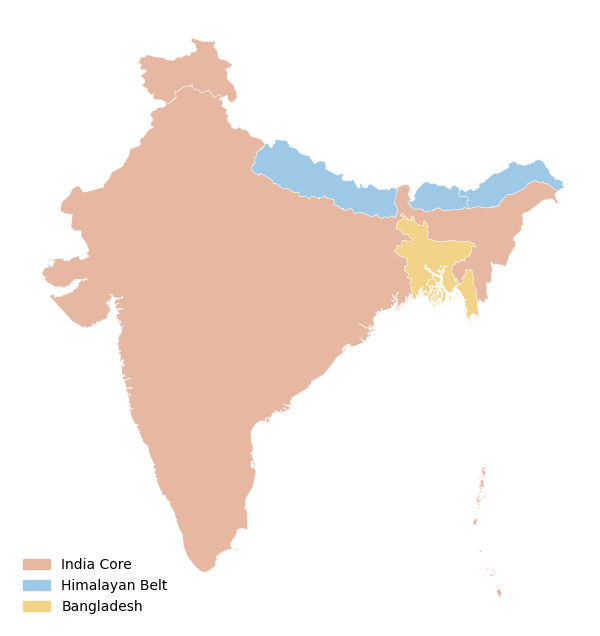

--- India Plus ---


,Region,Population (MM),GDP (BUSD),Electricity Consumption (TWh)
0,India Core,1450.94,3912.69,1714.47
1,Himalayan Belt,30.44,45.93,9.52
2,Bangladesh,173.56,450.12,104.60


In [97]:
# INDIA PLUS
INDIA_PLUS = ['India','Nepal','Bhutan','Arunachal Pradesh','Jammu and Kashmir','Bangladesh']

INDIA_PLUS_REGIONS = {
    "India Core": [
        "India", "Jammu and Kashmir"
    ],
    "Himalayan Belt": [
        "Nepal","Bhutan","Arunachal Pradesh"
    ],
    "Bangladesh": [
        "Bangladesh"
    ]
}

import matplotlib.patches as mpatches

colors = {
    "India Core": "#E6B8A2",
    "Himalayan Belt": "#9EC9E6",
    "Bangladesh": "#F2D388"
}

# --- ASSIGN SUBREGIONS ---
ind_gdf = gdf[gdf["NAM_0"].isin(INDIA_PLUS)].copy()
ind_gdf["INDIA_Region"] = None
for region, countries in INDIA_PLUS_REGIONS.items():
    ind_gdf.loc[ind_gdf["NAM_0"].isin(countries), "INDIA_Region"] = region

# --- LIGHTWEIGHT MAP ---
ind_plot = ind_gdf.copy()
ind_plot["geometry"] = ind_plot["geometry"].simplify(0.05, preserve_topology=True)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_IndiaPlus.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
ind_plot.plot(
    ax=ax,
    color=ind_plot["INDIA_Region"].map(colors),
    linewidth=0.3,
    edgecolor="white"
)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="lower left", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

india_stats = build_region_stats(INDIA_PLUS_REGIONS, "India Plus", gdf, stats_df)
display(india_stats)


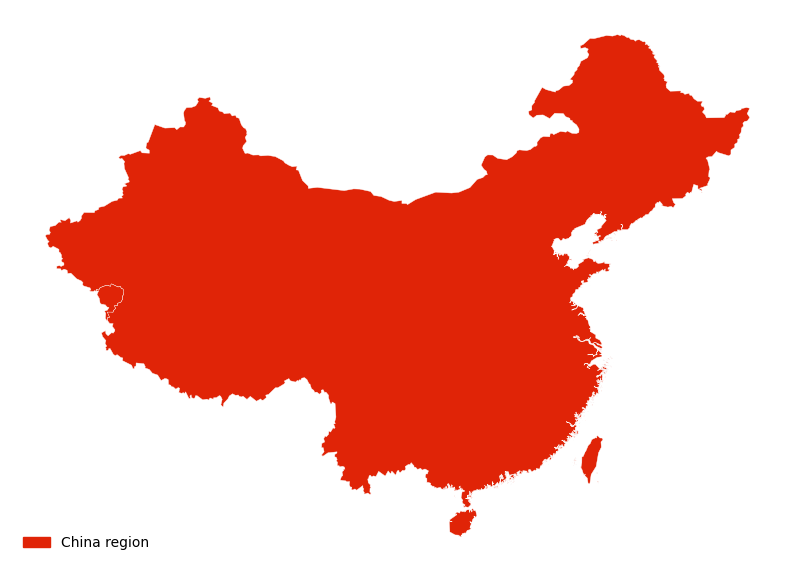

--- China Region ---


,Region,Population (MM),GDP (BUSD),Electricity Consumption (TWh)
0,China region,1417.19,19201.09,9239.72


In [99]:
# CHINA REGION
CHINA_REGION = ['China', 'Hong Kong SAR, China', 'Macau SAR, China', 'Aksai Chin']

CHINA_REGIONS = {
    "China region": [
        'China', 'Hong Kong SAR, China', 'Macau SAR, China', 'Aksai Chin'
    ]
}

import matplotlib.patches as mpatches

colors = {
    "China region": "#E02407"
}

# --- ASSIGN SUBREGIONS ---
china_gdf = gdf[gdf["NAM_0"].isin(CHINA_REGION)].copy()
china_gdf["CHINA_Region"] = None
for region, countries in CHINA_REGIONS.items():
    china_gdf.loc[china_gdf["NAM_0"].isin(countries), "CHINA_Region"] = region

# --- LIGHTWEIGHT MAP ---
china_plot = china_gdf.copy()
china_plot["geometry"] = china_plot["geometry"].simplify(0.05, preserve_topology=True)

out_dir = base_dir / "Maps" / "Layer1"
out_dir.mkdir(parents=True, exist_ok=True)
out_path = out_dir / "L1_ChinaRegion.pdf"

fig, ax = plt.subplots(1, 1, figsize=(10, 8))
china_plot.plot(
    ax=ax,
    color=china_plot["CHINA_Region"].map(colors),
    linewidth=0.3,
    edgecolor="white"
)

legend_handles = [mpatches.Patch(color=colors[k], label=k) for k in colors]
ax.legend(handles=legend_handles, loc="lower left", frameon=False)
ax.set_axis_off()

fig.savefig(out_path, dpi=150, bbox_inches="tight")
plt.show()

china_stats = build_region_stats(CHINA_REGIONS, "China Region", gdf, stats_df)
display(china_stats)
